Source: [part 2](https://github.com/bentrevett/pytorch-seq2seq/blob/master/2%20-%20Learning%20Phrase%20Representations%20using%20RNN%20Encoder-Decoder%20for%20Statistical%20Machine%20Translation.ipynb)

In [1]:
import os
from IPython.display import Image 

pth = os.getcwd()
pth

'/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/NLPstudy'

# 2 - Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation

In this second notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from [Paper - Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078). This model will achieve improved test perplexity whilst only using a single layer RNN in both the encoder and the decoder.

## Introduction

Let's remind ourselves of the general encoder-decoder model.


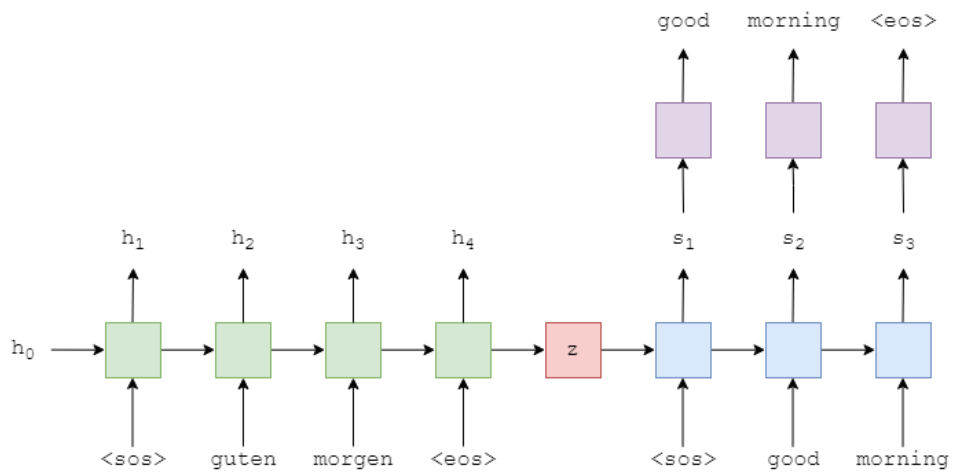

In [2]:
Image(filename = pth + "/images/generalEncDecModel.png")


We use our encoder (green) over the source sequence to create a context vector (red). We then use that context vector with the decoder (blue) and a linear layer (purple) to generate the target sentence.

In the previous model, we used an multi-layered LSTM as the encoder and decoder.


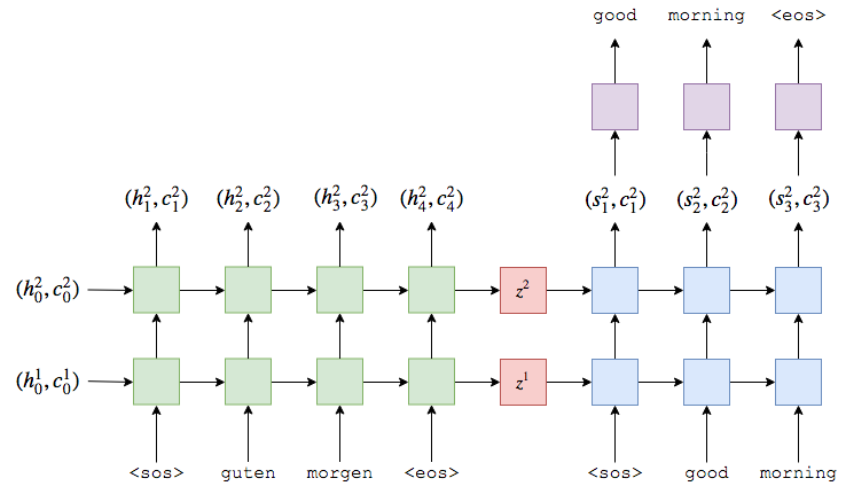

In [3]:
Image(filename = pth + "/images/seq2seq.png")

One downside of the previous model is that the decoder is trying to cram lots of information into the hidden states. 
Whilst decoding, the hidden state will need to contain information about the whole of the source sequence, as well as all of the tokens have been decoded so far. **By alleviating some of this information compression, we can create a better model**

We'll also be using a GRU (Gated Recurrent Unit) instead of an LSTM (Long Short-Term Memory). 
This [Paper - Empirical Evaluation of Gated Recurrent Networks on Sequence Modeling](https://arxiv.org/abs/1412.3555) has shown GRU's and LSTMs perform similarly, and both are better than standard RNNs.

## Preparing Data

All of the data preparation will be (almost) the same as in part 1. See previous notebook for deeper details. 

We'll import PyTorch, TorchText, spaCy and a few standard modules.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.tensor as Tensor

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

In [5]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### 1. Create the Tokenizers

Next, we'll create the tokenizers. A tokenizer is used to turn a string containing a sentence into a list of individual tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"]. 

spaCy has model for each language ("de" for German and "en" for English) which need to be loaded so we can access the tokenizer of each model.

In [6]:
# Download the spacy models via command line:
# conda activate pynlp_env
# cd /development/.../NLPStudy/data
# python -m spacy download en
# python -m spacy download de

# Then load the models
spacyDE = spacy.load('de')
spacyEN = spacy.load('en')

### 2. Create the Tokenizer Functions

Next, we create the tokenizer functions. These can be passed to TorchText and will take in the sentence as a string and return the sentence as a list of tokens.

In [7]:
# Creating the tokenizer functions
# NOTE: not reversing source (German) anymore.

def tokenizeGerman(germanText: str):
    """
    Tokenizes German text from a string into a list of strings (as tokens)
    :param germanText: 
    :return: 
    """
    return [tok.text for tok in spacyDE.tokenizer(germanText)]

def tokenizeEnglish(englishText: str):
    """
    Tokenizes English text from a string into a list of strings (as tokens)
    and reverses it
    
    :param englishText: 
    :return: 
    """
    return [tok.text for tok in spacyEN.tokenizer(englishText)]

We set the tokenize argument to the correct tokenization function for each, with German being the `SRC` (source) field and English being the `TRG` (target) field. The `Field` also appends the "start of sequence" and "end of sequence" tokens via the `init_token` and `eos_token` arguments, and converts all words to lowercase.

[To read more about Field's arguments](https://github.com/pytorch/text/blob/master/torchtext/data/field.py#L61)


In [8]:
# German = source language, English = target language

# tokenize:  The function used to tokenize strings using this field into
#             sequential examples.
# init_token: A token that will be prepended to every example using this
#             field, or None for no initial token. Default: None.
# eos_token: A token that will be appended to every example using this
#             field, or None for no end-of-sentence token. Default: None.
# lower: Whether to lowercase the text in this field. Default: False.
SRC = Field(tokenize = tokenizeGerman,
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

TRG = Field(tokenize = tokenizeEnglish,
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

### 3. Download the Data

Next, we download and load the train, validation and test data.

The dataset we'll be using is the [Multi30k dataset](https://github.com/multi30k/dataset).
This is a dataset with ~30,000 parallel English, German and French sentences, each with ~12 words per sentence.

In [9]:
# `exts` : specifies which languages to use as the source and target
# (source goes first) 
# `fields`: specifies which field to use for the source and target.

# NOTE: after this, the data is stored in 
# a folder under NLPSTUDY called '.data'
trainData, validationData, testData = \
    Multi30k.splits(exts = ('.de', '.en'),
                    fields = (SRC, TRG))

In [10]:
# Print out examples to verify the source (German) is not reversed ...

# Double-checking we have the right number of examples: 
print(f"Number of training examples: {len(trainData.examples)}")
print(f"Number of validation examples: {len(validationData.examples)}")
print(f"Number of testing examples: {len(testData.examples)}")

print("\n")

# Printing out an example to make sure the source sentence is
# not reversed (if you know German); the target (english) is in proper order, though. 
print(trainData.examples[0])
print(vars(trainData.examples[0]))

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


### 4. Building the vocabulary

Next, we build the *vocabulary* for the source and target languages.

The vocabulary is used to associate each unique token (word) with an index (an integer), similar to the way a dictionary works.

This is used to build a one-hot encoding for each token (a vector of all zeros except for the position represented by the index, which is 1).

The vocabularies of the source and target languages are distinct.

Using the `min_freq` argument, we only allow tokens that appear at least 2 times to appear in our vocabulary. Tokens that appear only once are converted into an `<unk>` (unknown) token.

WARNING: It is important to note that your vocabulary should only be built from the training set and not the validation/test set. This prevents "information leakage" into your model, giving you artifically inflated validation/test scores.

In [11]:
SRC.build_vocab(trainData, min_freq=2)
TRG.build_vocab(trainData, min_freq=2)

In [12]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


### 5. (Final) Create the Iterators

The final step of preparing the data is to create the iterators. These can be iterated on to return a batch of data which will have a `src` attribute (the PyTorch tensors containing a batch of numericalized source sentences) and a `trg` attribute (the PyTorch tensors containing a batch of numericalized target sentences). Numericalized is just a fancy way of saying they have been converted from a sequence of readable tokens to a sequence of corresponding indexes, using the vocabulary.

We also need to define a `torch.device`. This is used to tell TorchText to put the tensors on the GPU or not. We use the `torch.cuda.is_available()` function, which will return `True` if a GPU is detected on our computer. We pass this `device` to the iterator.

When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length, the same with the target sentences. Luckily, TorchText iterators handle this for us!

We use a `BucketIterator` instead of the standard `Iterator` as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences. 

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [14]:
# Creating the training iterator

BATCH_SIZE = 128

trainIterator, validationIterator, testIterator = BucketIterator.splits(
    (trainData, validationData, testData),
    batch_size = BATCH_SIZE,
    device = device)

## Building the Seq2Seq Model (GRU)

#### [GRU Formulation](https://hyp.is/FV-GHhAsEeqa9B_lR5PiZg/pytorch.org/docs/stable/nn.html)

For each element in the input sequence, each layer computes the following functions:

\begin{align*}
r_t &= \text{sigmoid}(W_{ir} x_t + b_{ir} + W_{hr} h_{t-1} + b_{hr}) \\
z_t &= \text{sigmoid}(W_{iz} x_t + b_{iz} + W_{hz} h_{t-1} + b_{hz}) \\
n_t &= \text{tanh}(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{t-1} + b_{hn})) \\
h_t &= (1 - z_t) * n_t + z_t + h_{t-1} \\
\end{align*}

##### Variable Meanings in GRU: 
- $x_t$ = the input at time $t$
- $h_t$ = the hidden state at time $t$
- $h_{t-1}$ = the hidden state of the layer at time $t-1$ or the initial hidden state at time $0$.
- $r_t$ = the reset gate. When the reset gate value is close to $0$, the hidden state is forced to ignore the previous hidden state and reset with the current input only. This allows the hidden state to drop any irrelevant information in the future.
- $z_t$ = the update gate. The update gate controls how much information from the previous hidden state carries to the current hidden state, acting like the memory cell in LSMT, to help remember long-term information.
- $n_t$ = the new gate
- $*$ = the Hadamard product

[**NOTE:**](https://hyp.is/XvhiShAyEeqvoV-jOpBdJw/arxiv.org/pdf/1406.1078.pdf) As each hidden unit has separate reset and update gates, each hidden unit can learn to capture dependencies over different time scales. So now we have a hidden unit that adaptively remembers and forgets, determined by time. 
Those units that learn to capture short-term dependencies will have reset gates that are frequently active, but those that capture longer-term dependencies will have update gates that are mostly active. 

- $W_{ih}$ = tensor containing the learnable input-to-hidden weights of the layers. Has shape (3 * `hiddenSize`, `inputSize`) for $k = 0$, else the shape is (3 * `hiddenSize`, `numDirections` * `hiddenSize`). 
- Refers to: 
	- $W_{ir}$ = input-to-hidden weights for all layers for the reset gate
	- $W_{iz}$ = input-to-hidden weights for all layers for the update gate
	- $W_{in}$ = input-to-hidden weights for all layers for the new gate

- $W_{hh}$ = tensor containing the learnable hidden-to-hidden weights of the layers. Has shape (3 * `hiddenSize`, `hiddenSize`). 
- Refers to: 
	- $W_{hr}$ = hidden-to-hidden weights for all layers for the reset gate
	- $W_{hz}$ = hidden-to-hidden weights for all layers for the update gate
	- $W_{hn}$ = hidden-to-hidden weights for all layers for the new gate


- inputSize = the number of expected features in the input $X$
- hiddenSize = the number of features in the hidden state $h$
- numLayers = number of recurrent layers (setting it to 2 means stacking two GRUs to form a *stacked GRU*). 

##### [Inputs of GRU Model:](https://hyp.is/pBfL1BBNEeqtNBe_R-qBnQ/pytorch.org/docs/stable/nn.html)
- input = tensor of shape (`seqLen`, `batchSize`, `inputSize`) that contains the features of the input sequence.
- $h_0$ = tensor of shape (`numLayers` * `numDirections`, `batchSize`, `hiddenSize`) containing the initial hidden state for each element in the batch.

##### [Outputs of GRU Model:](https://hyp.is/srJishBNEeq9gDO7DA-0WQ/pytorch.org/docs/stable/nn.html)
- output = tensor of shape (`seqLen`, `batchSize`, `numDirections` * `hiddenSize`) that contains the output features $h_t$ from the last layer of the GRU, for each time step $t$. 
- $h_n$ = tensor of shape (`numLayers` * `numDirections`, `batchSize`, `hiddenSize`) containing the hidden state for $T =$ `seqLen`.


The GRU model (drawing) looks like: 

**NOTE:** the $\tilde{h}_t$ represents the new gate, $n_t$

[Image source](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

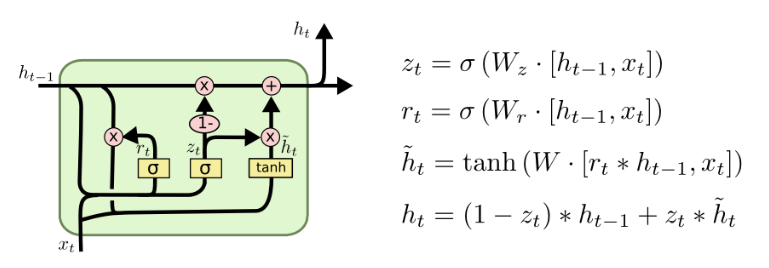

In [15]:
Image(filename = pth + "/images/gru.png")

### Encoder

The encoder is similar to the previous one, except a single-layer GRU is used instead of the multi-layer LSTM. 
Since the GRU is single-layer, this implies no dropout is needed as an argument to the GRU since dropout is only used between each layer of a multi-layered RNN. 
PyTorch will display a warning if we try to pass a dropout to the single-layer GRU. 

#### Contrasting GRU, LSTM, and general RNN: 

The GRU only requiresand returns a hidden state. There is no cell state like in the LSTM.

$$\begin{align*}
h_t &= \text{GRU}(x_t, h_{t-1}) \\
(h_t, c_t) &= \text{LSTM}(x_t, (h_{t-1}, c_{t-1})) \\
h_t &= \text{RNN}(x_t, h_{t-1}) \\
\end{align*}$$

From the equations above, it looks like the RNN and the GRU are identical. Inside the GRU, however, is a number of *gating mechanisms* that control the information flow in to and out of the hidden state (similar to an LSTM). 
The GRU combines the forget and input gates into a single "update gate" and merges the cell state and hidden state
. 
- NOTE: [more information](https://hyp.is/yELnnhAxEeqNwyMvDX6Pog/arxiv.org/pdf/1406.1078.pdf) is found in the [Paper - Learning Phrase Representations using RNN ENcoder-Decoder for Statistical Machine Translation](arxiv.org/pdf/1406.1078.pdf) has more details. 



The rest of the encoder should be very familar from the last tutorial, it takes in a sequence, $X = \{x_1, x_2, ... , x_T\}$, recurrently calculates hidden states, $H = \{h_1, h_2, ..., h_T\}$, and returns a context vector (the final hidden state), $z=h_T$.

$$h_t = \text{EncoderGRU}(x_t, h_{t-1})$$

This is identical to the encoder of the general seq2seq model, with more logic inside the GRU (green squares). 

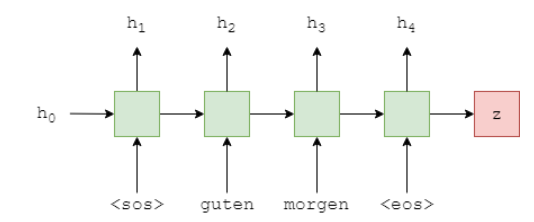

In [16]:
Image(filename = pth + "/images/encoderGRU.png")

In [51]:
class Encoder(nn.Module):
    def __init__(self, inputDim: int, embedDim: int, hiddenDim: int, dropout: int):
        
        super().__init__()
        
        self.hiddenDim = hiddenDim
        
        # NOTE: no dropout since GRU has only 1 layer!
        self.embeddingLayer = nn.Embedding(num_embeddings=inputDim, 
                                           embedding_dim=embedDim)
        
        self.rnn = nn.GRU(input_size=embedDim, hidden_size=hiddenDim)
        
        # During training, randomly zeroes some of the elements of the input tensor 
        # with probability p using samples from a Bernoulli distribution. Each channel 
        # will be zeroed out independently on every forward call.
        # Good for regularization
        # SOURCE: https://hyp.is/qrKgZg0-EeqHWhNj0dgBjw/pytorch.org/docs/stable/nn.html
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, src: Tensor) -> Tensor:
        """
        Passing the source sentence X (tensor) which has been converted into dense vectors
        using the embedding layer. 
        Then apply dropout. 
        Do recurrent calculation of hidden states over the whole sequence. 
        
        :param src: tensor X holding the input vectors x_1, ... x_T
        Has shape: (srcSentenceLen, batchSize)
        :return: 
            hidden: the final hidden state for each layer, h_T, stacked on top of each other
            This acts as the context vector `z` in the overall Seq2Seq model
        """
        # Convert the source sentence X to dense vectors using embedding layer
        srcEmbedding = self.dropout(self.embeddingLayer(src))
        # srcEmbedding shape: (srcSentenceLen, batchSize, embedDim)
        
        outputs, hidden = self.rnn(srcEmbedding) # no cell state returned since this RNN is GRU
        ## outputs shape: (srcSentenceLen, batchSize, hiddenDim * numDirections)
        ## hidden shape: (numLayers * numDirections, batchSize, hiddenDim)
        
        # NOTE: outputs are always from the top hidden layer
        
        return hidden  # context vector
    

## Decoder

The decoder is where the implementation differs significantly from the previous model and we alleviate some of the information compression.

Instead of the GRU in the decoder taking just the target token, $y_t$ and the previous hidden state $s_{t-1}$ as inputs, it also takes the context vector $z$.

$$s_t = \text{DecoderGRU}(y_t, s_{t-1}, z)$$

- **NOTE:** this context vector, $z$, does not have a $t$ subscript, meaning we re-use the same context vector returned by the encoder for every time-step in the decoder.

###### For LSTM Decoder: Before, we predicted the next token, $\hat{y}_{t+1}$, with the linear layer, $f$, only using the top-layer decoder hidden state at that time-step, $s_t$, as:
$$
\hat{y}_{t+1}=f(s_t^L)
$$
###### For GRU Decoder: Now, we also pass the current token, $\hat{y}_t$ and the context vector, $z$ to the linear layer:
$$
\hat{y}_{t+1} = f(y_t, s_t, z)
$$

Thus, our decoder now looks something like this:

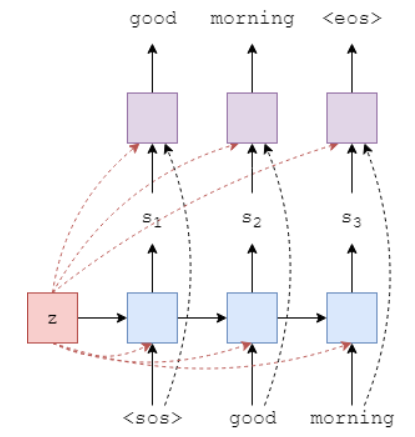

In [21]:
Image(filename=pth + "/images/decoderGRU.png")

- **Note**: the initial hidden state, $s_0$, is still the context vector, $z$, so when generating the first token we are actually inputting two identical context vectors into the GRU.

How do these two changes reduce the information compression? Well, hypothetically the decoder hidden states, $s_t$, no longer need to contain information about the source sequence as it is always available as an input. Thus, it only needs to contain information about what tokens it has generated so far. The addition of $y_t$ to the linear layer also means this layer can directly see what the token is, without having to get this information from the hidden state. 

    However, this hypothesis is just a hypothesis, it is impossible to determine how the model actually uses the information provided to it (don't listen to anyone that tells you differently). Nevertheless, it is a solid intuition and the results seem to indicate that this modifications are a good idea!

Within the implementation, we will pass $y_t$ and $z$ to the GRU by concatenating them together, so the input dimensions to the GRU are now `embedDim + hiddenDim` (as context vector will be of size `hiddenDim`). The linear layer will take $y_t, s_t$ and $z$ also by concatenating them together, hence the input dimensions are now `emb_dimembedDim+ hiddenDim*2`. We also don't pass a value of dropout to the GRU as it only uses a single layer.

##### Decoder GRU Forward Pass:
`forward` now takes a `context` argument. Inside of `forward`, we concatenate $y_t$ and $z$ as `contextEmbedding` before feeding to the GRU, and we concatenate $y_t$, $s_t$ and $z$ together as `output` before feeding it through the linear layer to receive our predictions, $\hat{y}_{t+1}$.

In [47]:
class Decoder(nn.Module):
    
    def __init__(self, outputDim:int, embedDim: int, hiddenDim: int, dropout: int):
        
        super().__init__()
        
        self.hiddenDim = hiddenDim
        self.outputDim = outputDim
        
        self.embeddingLayer = nn.Embedding(num_embeddings=outputDim, 
                                           embedding_dim=embedDim)
        
        self.rnn = nn.GRU(input_size=embedDim + hiddenDim, 
                          hidden_size=hiddenDim)
        
        self.outputLayer = nn.Linear(in_features=embedDim + hiddenDim * 2,
                                     out_features=outputDim)
        
        self.dropout = nn.Dropout(dropout)
        
    
    
    
    def forward(self, input: Tensor, hidden: Tensor, context: Tensor) -> (Tensor, Tensor):
        """
        
        NOTE: numLayers = numDirections = 1 in the Decoder, ALWAYS
        
        :param input: 
            shape: (batchSize)
        :param hidden: 
            shape = (numLayers * numDirections, batchSize, hiddenDim)
                  = (1, batchSize, hiddenDim)
        :param context: 
            shape = (numLayers * numDirections, batchSize, hiddenDim)
                  = (1, batchSize, hiddenDim)
            
        :return: 
            prediction: 
                shape = (batchSize, outputDim)
            hidden:
                shape =  (1, batchSize, hiddenDim)
        """
        
        # Adding a tensor of dim = 1 to the input
        input = input.unsqueeze(0)
        ## input shape now = (1, batchSize) 
        
        # Creating input embedding
        inputEmbedding = self.dropout(self.embeddingLayer(input))
        ## embedding shape = (1, batchSize, embedDim)
        
        # Create context embedding
        contextEmbedding = torch.cat((inputEmbedding, context), dim = 2)
        ## shape = (1, batchSize, embedDim + hiddenDim)
        
        output, hidden = self.rnn(contextEmbedding, hidden)
        ### note: numLayers = 1
        ### note: numDirections = 1
        ### note: sentenceLen = 1
        ## output shape = (sentenceLen, batchSize, hiddenDim * nuMDirections)
        ##              = (1, batchSize, hiddenDim)
        ## hidden shape = (numLayers * numDIrections, batchSize, hiddenDim)
        ##             = (1, batchSize, hiddenDim)
        
        # Use concatenate to combine the tensors on dimension dim = 0 (along batchSize dim)
        output = torch.cat((inputEmbedding.squeeze(0), # (batchSize, embedDim)
                            hidden.squeeze(0),         # (batchSize, hiddenDim)
                            context.squeeze(0)),       # (batchSize, hiddenDim)
                           dim = 1)
        ## output shape now = (batchSize, embedDim + hiddenDim * 2)
        
        # Create prediction
        prediction = self.outputLayer(output)
        ## prediction shape = (batchSize, outputDim)
        
        return prediction, hidden 

## Seq2Seq Model

Putting the encoder and decoder together, we get:

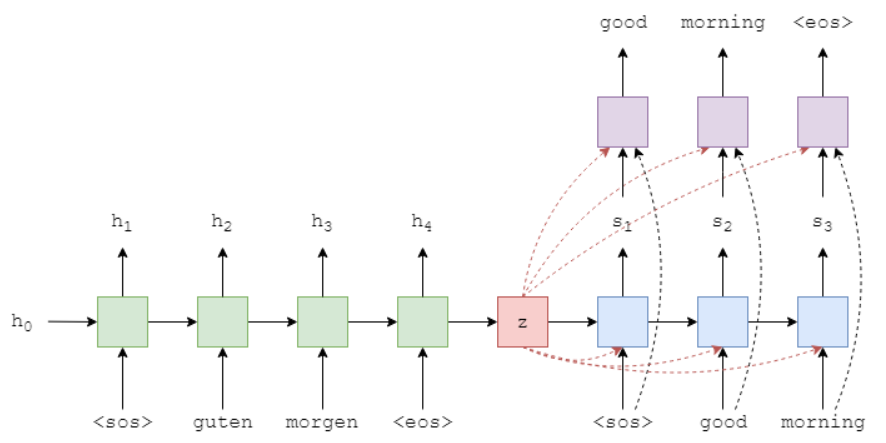

In [24]:
Image(filename = pth + "/images/seq2seqGRU.png")

Again, in this implementation we need to ensure the hidden dimensions in both the encoder and the decoder are the same.

##### Forward Pass of Seq2Seq GRU Model: 
1. the `outputs` tensor is created to hold all predictions, $\hat{Y}$
2. the source sequence, $X$, is fed into the `Encoder` GRU to receive a `context` vector
3. the initial `Decoder` hidden state is set to be the `context` vector, $s_0 = z = h_T$
4. we use a batch of `<sos>` tokens as the first `input`, $y_1$
5. we then decode within a loop:
- inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and the context vector, $z$, into the `Decoder`
- receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
- we then decide if we are going to teacher force or not, setting the next input as appropriate (either the ground truth next token in the target sequence or the highest predicted next token)

In [53]:
class Seq2Seq(nn.Module):
    
    def __init__(self, encoder: Encoder, decoder: Decoder, device):
        
        super().__init__()
        
        self.encoder: Encoder = encoder
        self.decoder: Decoder = decoder
        self.device = device
        
        assert encoder.hiddenDim == decoder.hiddenDim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        

    def forward(self, src: Tensor, trg: Tensor, teacherForcingRatio: float = 0.5) -> Tensor:
        """
        1. the `outputs` tensor is created to hold all predictions, Y-hat
        2. the source sequence, $X$, is fed into the `Encoder` GRU to receive a `context` 
        vector
        3. the initial `Decoder` hidden state is set to be the `context` vector, 
        s_0 = z = h_T
        4. we use a batch of `<sos>` tokens as the first `input`, y_1
        5. we then decode within a loop:
        - a) inserting the input token y_t, previous hidden state, s_{t-1}, 
        and the context vector, z, into the `Decoder`
        - b) receiving a prediction, y_{t+1}-hat, and a new hidden state, s_t
        - c) we then decide if we are going to teacher force or not, 
        setting the next input as appropriate.
        
        :param src: source sequence tensor X = {x_1, ..., x_T}, used as input into Encoder
        to retrieve a context vector
            shape: (srcSentenceLen, batchSize)
        :param trg: target sequence / sentence tensor
            shape: (trgSentenceLen, batchSize)
        :param teacherForcingRatio: probability of using teacher forcing (of using
        ground-truth inputs)
        
        :return: 
            outputs
                shape: (??)
        """
        
        maxLen, batchSize = trg.shape
        trgVocabSize: int = self.decoder.outputDim
        
        # Step 1: Create tensor to store decoder outputs
        outputs: Tensor = torch.zeros(maxLen, batchSize, trgVocabSize).to(self.device)
        
        # Step 2: Feed source sequence X (src) into Encoder to get context vector
        context: Tensor = self.encoder(src)
        
        # Step 3: set the initial decoder hidden state to be the final encoder context state
        # s_0 = z = h_T
        hidden: Tensor = context
        
        # Step 4: First input to the decoder is the <sos> tokens
        input: Tensor = trg[0, :]
        
        
        # Step 5: Decoding in a loop
        for t in range(1, maxLen):
            
            # Step 5.a) insert input token embedding (y_t), previous hidden state (s_t-1), 
            # and context state (z) into the decoder
            output, hidden = self.decoder(input, hidden, context)
            
            # Step 5.b) Place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            # Step 5.c) Decide if using teacher forcing or not
            useTeacherForcing: bool = random.random() < teacherForcingRatio
            
            # Get the hidghest predicted token from our predictions
            highestProbToken: Tensor = output.argmax(1) # returns indices of max value of all elements in output tensor
            
            # If teacher forcing, use actual next token as next input, 
            # else, use predicted token
            input: Tensor = trg[t] if useTeacherForcing else highestProbToken
            ## shape: trg is shape (trgSentenceLen, batchSize) so input is now
            # shape (batchSize)
            
        return outputs 

# Training the Seq2Seq Model

The rest of this tutorial is very similar to the previous one.

## Step 1: Initialize the Seq2Seq (GRU) Model

We initialise our encoder, decoder and seq2seq model (placing it on the GPU if we have one). As before, the embedding dimensions and the amount of dropout used can be different between the encoder and the decoder, but the hidden dimensions must remain the same.

In [60]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

encoderGRU = Encoder(inputDim = INPUT_DIM, 
                     embedDim=ENC_EMB_DIM,
                     hiddenDim=HID_DIM,
                     dropout=ENC_DROPOUT)

decoderGRU = Decoder(outputDim=OUTPUT_DIM,
                     embedDim=DEC_EMB_DIM,
                     hiddenDim=HID_DIM,
                     dropout=DEC_DROPOUT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seq2seqGRUModel = Seq2Seq(encoder = encoderGRU, decoder=decoderGRU, device=device).to(device)


In [56]:
device

device(type='cpu')

In [61]:
seq2seqGRUModel

Seq2Seq(
  (encoder): Encoder(
    (embeddingLayer): Embedding(7853, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (embeddingLayer): Embedding(5893, 256)
    (rnn): GRU(768, 512)
    (outputLayer): Linear(in_features=1280, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

## Step 2: Initialize the Weights of the Seq2Seq (GRU) Model

Next, we initialize our parameters. The paper states the parameters are initialized from a normal distribution with a mean of 0 and a standard deviation of 0.01, i.e. $\mathcal{N}(\mu=0, \sigma=0.01)$. 

It also states we should initialize the recurrent parameters to a special initialization, however to keep things simple we'll also initialize them to $\mathcal{N}(\mu=0, \sigma=0.01)$.

In [59]:
def initWeights(model: Seq2Seq):
    for  name, param in model.named_parameters():
        nn.init.normal_(tensor = param.data, mean=0, std=0.01)


In [62]:
seq2seqGRUModel.apply(initWeights)

Seq2Seq(
  (encoder): Encoder(
    (embeddingLayer): Embedding(7853, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (embeddingLayer): Embedding(5893, 256)
    (rnn): GRU(768, 512)
    (outputLayer): Linear(in_features=1280, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

### Step 3: Print Out Parameters

Define a function to calculate number of trainable parameters in the model.

Even though we only have a single layer RNN for our encoder and decoder we actually have **more** parameters  than the last model. This is due to the increased size of the inputs to the GRU and the linear layer. However, it is not a significant amount of parameters and causes a minimal amount of increase in training time (~3 seconds per epoch extra).

In [63]:
def countParameters(model: Seq2Seq):
    # note: trainable parameters means ones that have requires_grad = True
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [64]:
print(f'The model has {countParameters(seq2seqGRUModel):,} trainable parameters')

The model has 14,219,781 trainable parameters


### Step 4: Initialize the Optimizer (Adam)

In [67]:
adamOptimizer = optim.Adam(seq2seqGRUModel.parameters())
adamOptimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

### Step 5: Define the Loss Function (Cross Entropy)

Make sure to ignore the loss on `<pad>` tokens.

In [73]:
PAD_INDEX = TRG.vocab.stoi['<pad>']

crossEntropyLossFunction = nn.CrossEntropyLoss(ignore_index = PAD_INDEX)
crossEntropyLossFunction

CrossEntropyLoss()

### Step 6: Define the Training Loop

- **NOTE:** same as part 1

Next, we'll define our training loop. 

First, we'll set the model into "training mode" with `model.train()`. This will turn on dropout (and batch normalization, which we aren't using) and then iterate through our data iterator.

- **NOTE:**: the `Decoder` loop starts at 1, not 0. This means the 0th element of our `outputs` tensor remains all zeros. So our `trg` and `outputs` look something like:

$$\begin{align*}
\text{trg} = [<sos>, &y_1, y_2, y_3, <eos>]\\
\text{outputs} = [0, &\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

Here, when we calculate the loss, we cut off the first element of each tensor to get:

$$\begin{align*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\\
\text{outputs} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

At each iteration:
- get the source and target sentences from the batch, $X$ and $Y$
- zero the gradients calculated from the last batch
- feed the source and target into the model to get the output, $\hat{Y}$
- as the **loss function only works on 2d inputs with 1d targets we need to flatten each of them with `.view`**
    - we slice off the first column of the output and target tensors as mentioned above
- calculate the gradients with `loss.backward()`
- clip the gradients to prevent them from exploding (a common issue in RNNs)
- update the parameters of our model by doing an optimizer step
- sum the loss value to a running total

Finally, we return the loss that is averaged over all batches.

In [70]:
def train(seqModel: Seq2Seq, iterator, optimizer, lossFunction, clip: int):

    seqModel.train()

    lossPerEpoch: int = 0

    for epoch, batch in enumerate(iterator):

        # 1. Getting source and target sentences from batch
        srcSentence = batch.src
        trgSentence = batch.trg

        # 2. Zero the gradients from the last batch
        optimizer.zero_grad()

        # 3. Feed the source and target sentences into the seq2seq model
        # to get the output tensor of predictions.
        output: Tensor = seqModel(srcSentence, trgSentence)
        ### trgSentence = tensor of shape (trgSentenceLen, batchSize)
        ### output = tensor of shape (trgSentenceLen, batchSize, outputDim)

        # 4. Need to flatten the outputs to be in 2d input with 1d target
        # so that loss can take this as an argument. 
        # (by slicing off the first column of the output and target tensors
        # as mentioned above)
        output = output[1:].view(-1, output.shape[-1])
        trgSentence = trgSentence[1:].view(-1)
        ## trgSentence shape now: ((trgSentenceLen - 1) * batchSize)
        ## output shape now: ((trgSentenceLen - 1) * batchSize, outputDim)

        # 5. Calculate gradients
        loss = lossFunction(input=output, target= trgSentence)
        loss.backward()

        # 6. Clip gradient so it doesn't explode
        torch.nn.utils.clip_grad_norm_(parameters = seqModel.parameters(),
                                       max_norm = clip)

        # 7. Update parameters of model
        optimizer.step()

        # 8. Sum the loss value to a running total
        lossPerEpoch += loss.item()

    return lossPerEpoch / len(iterator) # average loss

### Step 7: Define the Evaluation Loop

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

*We must remember to set the model to evaluation mode with `model.eval()`. This will turn off dropout (and batch normalization, if used).*

We use the `with torch.no_grad()` block to ensure no gradients are calculated within the block. This reduces memory consumption and speeds things up.

The iteration loop is similar (without the parameter updates), however we must ensure we turn teacher forcing off for evaluation. This will cause the model to only use it's own predictions to make further predictions within a sentence, which mirrors how it would be used in deployment.

In [71]:
def evaluate(seqModel: Seq2Seq, iterator, lossFunction):

    seqModel.eval()

    lossPerEpoch = 0

    with torch.no_grad():

        for epoch, batch in enumerate(iterator):
            srcSentence = batch.src
            trgSentence = batch.trg

            # Turn off teacher forcing
            output = seqModel(srcSentence, trgSentence, 0)
            ## trgSentence = tensor with shape (trgSentenceLen, batchSize)
            ## output = tensor with shape (trgSentenceLen, batchSize, outputDim)

            output = output[1:].view(-1, output.shape[-1])
            trgSentence = trgSentence[1:].view(-1)
            ## trgSentence = shape is now ((trgSentenceLen - 1) * batchSize)
            ## output = shape is now ((trgSentenceLen - 1) * batchSize, outputDim)

            loss = lossFunction(output, trgSentence)

            lossPerEpoch += loss.item()


    return lossPerEpoch / len(iterator) # average loss
            
            

In [72]:
# Time the epoch!

def epochTimer(startTime, endTime):
    elapsedTime = endTime - startTime
    elapsedMins = int(elapsedTime / 60)
    elapsedSecs = int(elapsedTime - (elapsedMins * 60))
    return elapsedMins, elapsedSecs

In [74]:
%%time

NUM_EPOCHS = 10
CLIP = 1

bestValidLoss = float('inf')

for epoch in range(NUM_EPOCHS):

    startTime = time.time()

    trainingLoss = train(seqModel=seq2seqGRUModel, iterator=trainIterator,
                         optimizer=adamOptimizer, lossFunction=crossEntropyLossFunction,
                         clip=CLIP)

    validationLoss = evaluate(seqModel=seq2seqGRUModel,
                              iterator=validationIterator,
                              lossFunction=crossEntropyLossFunction)

    endTime = time.time()

    epochMins, epochSecs = epochTimer(startTime , endTime)

    if validationLoss < bestValidLoss:
        bestValidLoss = validationLoss
        torch.save(seq2seqGRUModel.state_dict(), 'tut2_seq2seqGRU_bestModel.pt')


    print(f'Epoch: {epoch+1:02} | Time: {epochMins}m {epochSecs}s')
    print(f'\tTrain Loss: {trainingLoss:.3f} | Train PPL: {math.exp(trainingLoss):7.3f}')
    print(f'\t Val. Loss: {validationLoss:.3f} |  Val. PPL: {math.exp(validationLoss):7.3f}')

In [ ]:

# We'll load the parameters (state_dict) that gave our model the best 
# validation loss and run it the model on the test set.

seq2seqGRUModel.load_state_dict(torch.load('tut2_seq2seqGRU_bestModel.pt'))

testLoss = evaluate(seq2seqGRUModel, testIterator, crossEntropyLossFunction)

# show test loss and calculate test perplexity score: 
print(f'| Test Loss: {testLoss:.3f} | Test PPL: {math.exp(testLoss):7.3f} |')

Just looking at the test loss, we get better performance. This is a pretty good sign that this model architecture is doing something right! Relieving the information compression seems like the way forard, and in the next tutorial we'll expand on this even further with attention.